<a href="https://colab.research.google.com/github/Juju-shtorm/projects/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import matplotlib.patches as mpatches
import seaborn as sb
import ipywidgets
import requests

# Данные

После того как появились новости о новом штамме ковида, мне стало интересно проанализировать данные о заболеваемостях и смертностях от вируса в различных странах за четыре года. Лучше всего для этого подойдут данные ВОЗ(WHO)

In [9]:
req = requests.get("https://covid19.who.int/WHO-COVID-19-global-data.csv")
url_content = req.content
csv_file = open('data_cov.csv', 'wb')
csv_file.write(url_content)
csv_file.close()

data_cov = pd.read_csv('data_cov.csv')

In [10]:
data_cov

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,EMRO,NaN,0,NaN,0
1,2020-01-12,AF,Afghanistan,EMRO,NaN,0,NaN,0
2,2020-01-19,AF,Afghanistan,EMRO,NaN,0,NaN,0
3,2020-01-26,AF,Afghanistan,EMRO,NaN,0,NaN,0
4,2020-02-02,AF,Afghanistan,EMRO,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...
55195,2024-04-28,ZW,Zimbabwe,AFRO,3.0,266362,NaN,5740
55196,2024-05-05,ZW,Zimbabwe,AFRO,NaN,266362,NaN,5740
55197,2024-05-12,ZW,Zimbabwe,AFRO,NaN,266362,NaN,5740
55198,2024-05-19,ZW,Zimbabwe,AFRO,NaN,266362,NaN,5740


**Date_reported** - дата наблюдения

**Country_code** - двухбуквенный код страны

**Country** - название страны

**WHO_region** - регион ВОЗ к которому относиться страна

**New_cases** - новые подтвержденные случаи заболеваемости в эту дату

**Cumulative_cases** - общее число случаев заболеваемости на данную дату

**New_deaths** - новые подтвержденные смертельные исходы в эту дату

**Cumulative_deaths** - общее число смертельных исходов на данную дату



Рассмотрим количествов пустых ячеек в таблице

In [12]:
data_cov.isnull().sum()

Date_reported            0
Country_code           230
Country                  0
WHO_region            4140
New_cases            17045
Cumulative_cases         0
New_deaths           30444
Cumulative_deaths        0
dtype: int64

Заполним пустые ячейки в New_cases и New_deaths на нули


In [15]:
data_cov[['New_cases','New_deaths']] = data_cov[['New_cases','New_deaths']].fillna(0)

Посмотрим почему у некторых стран нет кода

In [26]:
data_cov[data_cov[['Country_code']].isnull().any(axis=1)]

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
34270,2020-01-05,NaN,Namibia,AFRO,0.0,0,0.0,0
34271,2020-01-12,NaN,Namibia,AFRO,0.0,0,0.0,0
34272,2020-01-19,NaN,Namibia,AFRO,0.0,0,0.0,0
34273,2020-01-26,NaN,Namibia,AFRO,0.0,0,0.0,0
34274,2020-02-02,NaN,Namibia,AFRO,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...
34495,2024-04-28,NaN,Namibia,AFRO,0.0,172404,0.0,4108
34496,2024-05-05,NaN,Namibia,AFRO,1.0,172405,0.0,4108
34497,2024-05-12,NaN,Namibia,AFRO,1.0,172406,0.0,4108
34498,2024-05-19,NaN,Namibia,AFRO,2.0,172408,0.0,4108


Для Намибии просто не предоставлен код

Одновременно код и название страны нам не нужны

In [27]:
data_cov = data_cov.drop(['Country_code'], axis=1)

Посмотрим на регионы

In [28]:
data_cov['WHO_region'].unique()

array(['EMRO', 'EURO', 'AFRO', 'WPRO', 'AMRO', 'SEARO', 'OTHER', nan],
      dtype=object)

Страны где не указан регион

In [30]:
data_oth = data_cov[data_cov['WHO_region']=='OTHER']
data_oth['Country'].unique()

array(['Charo', 'Chefoo', 'Diamond', 'Fesco', 'Ickiribati', 'Icvanuatu'],
      dtype=object)

In [34]:
data_na = data_cov[data_cov[['WHO_region']].isnull().any(axis=1)]
data_na['Country'].unique()

array(['Falkland Islands (Malvinas)', 'Faroe Islands', 'French Guiana',
       'Gibraltar', 'Guadeloupe', 'Guernsey', 'Holy See', 'Isle of Man',
       'Jersey', 'Liechtenstein', 'Martinique', 'Mayotte', 'Pitcairn',
       'Réunion', 'Saint Barthélemy', 'Saint Helena',
       'Saint Martin (French part)', 'Saint Pierre and Miquelon'],
      dtype=object)

# Регионы ВОЗ

Скачаем список стран с указаными регионами. Данные взяты с https://ourworldindata.org/grapher/who-regions?tab=table

In [48]:
from google.colab import files
uploaded = files.upload()

Saving who-regions.csv to who-regions.csv


In [49]:
data_reg = pd.read_csv('who-regions.csv')
data_reg

,Entity,Code,Year,WHO region
0,Afghanistan,AFG,2020,Eastern Mediterranean
1,Albania,ALB,2020,Europe
2,Algeria,DZA,2020,Africa
3,Andorra,AND,2020,Europe
4,Angola,AGO,2020,Africa
...,...,...,...,...
189,Venezuela,VEN,2020,Americas
190,Vietnam,VNM,2020,Western Pacific
191,Yemen,YEM,2020,Eastern Mediterranean
192,Zambia,ZMB,2020,Africa


In [59]:
data_reg['WHO region'].replace({'Eastern Mediterranean': 'EMRO', 'Europe': 'EURO', 'Africa': 'AFRO', 'Americas': 'AMRO', 'Western Pacific': 'WPRO', 'South-East Asia': 'SEARO'}, inplace=True)

Скачаем данные с континентами для геопандас. Далее заменим названия континентов на регионы

In [60]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

2024-06-08 09:12:08 [warning  ] The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/. category=FutureWarning filename=<ipython-input-60-a3f0fe4abfc1> lineno=1


In [61]:
for name in world['name'].values:
    if name in data_reg['Entity'].values:
        reg = data_reg[data_reg['Entity']==name].iloc[0,3]
        world.loc[world[world['name']==name].index.to_list(),'continent'] = reg
    else:
        world.loc[world[world['name']==name].index.to_list(),'continent'] = np.NaN

Посмотрим где данные не заполнены и заполним их вручную

In [62]:
world[world.isnull().any(axis=1)]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
2,603253.0,NaN,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
4,328239523.0,NaN,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
11,86790567.0,NaN,Dem. Rep. Congo,COD,50400,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
17,10738958.0,NaN,Dominican Rep.,DOM,88941,"POLYGON ((-71.70830 18.04500, -71.68774 18.316..."
20,3398.0,NaN,Falkland Is.,FLK,282,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."
22,56225.0,NaN,Greenland,GRL,3051,"POLYGON ((-46.76379 82.62796, -43.40644 83.225..."
23,140.0,NaN,Fr. S. Antarctic Lands,ATF,16,"POLYGON ((68.93500 -48.62500, 69.58000 -48.940..."
24,1293119.0,NaN,Timor-Leste,TLS,2017,"POLYGON ((124.96868 -8.89279, 125.08625 -8.656..."
45,3193694.0,NaN,Puerto Rico,PRI,104988,"POLYGON ((-66.28243 18.51476, -65.77130 18.426..."
60,25716544.0,NaN,Côte d'Ivoire,CIV,58539,"POLYGON ((-8.02994 10.20653, -7.89959 10.29738..."


In [63]:
world.loc[2,'continent'] = 'AFRO'
world.loc[11,'continent'] = 'AFRO'
world.loc[23,'continent'] = 'AFRO'
world.loc[60, 'continent'] = 'AFRO'
world.loc[66, 'continent'] = 'AFRO'
world.loc[69, 'continent'] = 'AFRO'
world.loc[73, 'continent'] = 'AFRO'
world.loc[167, 'continent'] = 'AFRO'
world.loc[176, 'continent'] = 'AFRO'

world.loc[4,'continent'] = 'AMRO'
world.loc[17,'continent'] = 'AMRO'
world.loc[45,'continent'] = 'AMRO'
world.loc[159,'continent'] = 'AMRO'

world.loc[20,'continent'] = 'EURO'
world.loc[22,'continent'] = 'EURO'
world.loc[160,'continent'] = 'EURO'
world.loc[170,'continent'] = 'EURO'
world.loc[174,'continent'] = 'EURO'

world.loc[24,'continent'] = 'SEARO'

world.loc[79, 'continent'] = 'EMRO'

world.loc[134, 'continent'] = 'WPRO'
world.loc[135, 'continent'] = 'WPRO'
world.loc[140, 'continent'] = 'WPRO'

Покажем на карте как расположены эти регионы

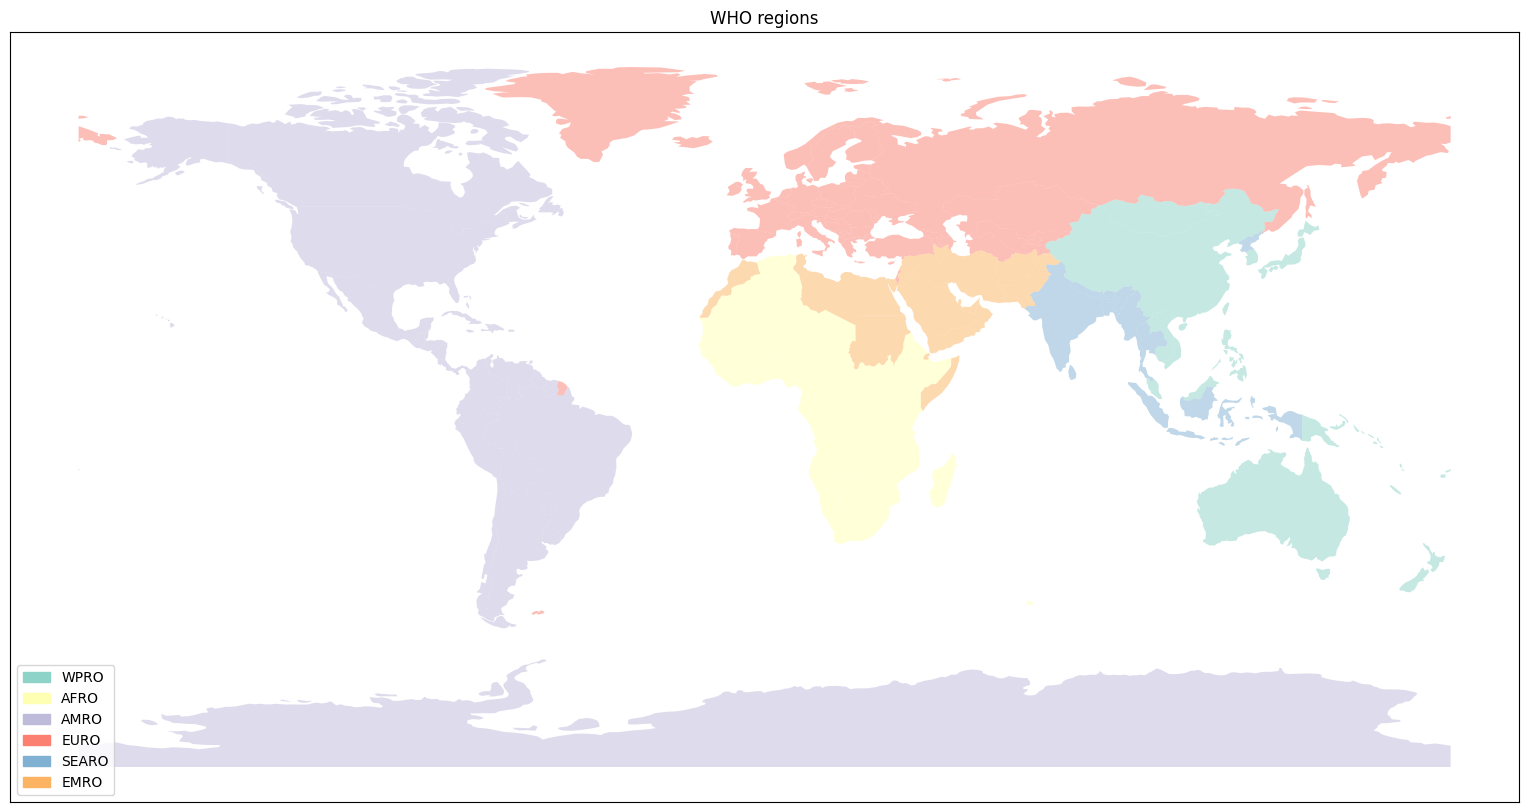

In [64]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

continents = world["continent"].unique()
colors = sns.color_palette("Set3", len(continents))
patches = []


for (continent_name, color) in list(zip(continents, colors)):
    continent = world[world["continent"] == continent_name]
    continent.plot(ax=ax, color=color, alpha=0.5)
    patch = mpatches.Patch(label=continent_name, color=color)
    patches.append(patch)


ax.legend(handles=patches, loc="lower left")
ax.set_xticks([])
ax.set_yticks([])
plt.title("WHO regions")
plt.show()

# Заболеваемость в разных регионах

Добавим новый столбец, где покажем долю смертей в различных странах в итоге

In [82]:
data1 = data_cov[['WHO_region','Country', 'New_cases', 'New_deaths']].groupby(['Country','WHO_region']).sum()
data1['death_coef'] = data1['New_deaths']/data1['New_cases']
data1.reset_index(inplace= True )
data1

,Country,WHO_region,New_cases,New_deaths,death_coef
0,Afghanistan,EMRO,235214.0,7998.0,0.034003
1,Albania,EURO,334863.0,3605.0,0.010766
2,Algeria,AFRO,272032.0,6881.0,0.025295
3,American Samoa,WPRO,8359.0,34.0,0.004067
4,Andorra,EURO,48015.0,159.0,0.003311
...,...,...,...,...,...
217,Wallis and Futuna,WPRO,3760.0,9.0,0.002394
218,Yemen,EMRO,11945.0,2159.0,0.180745
219,Zambia,AFRO,349653.0,4069.0,0.011637
220,Zimbabwe,AFRO,266362.0,5740.0,0.021550


Найдем среднюю смертность по регионам. Замети, что она меньше всего в Европе, а больше всего в Африке

In [70]:
death_reg = data1.groupby('WHO_region')['death_coef'].mean()
death_reg

WHO_region
AFRO     0.015736
AMRO     0.014052
EMRO     0.028009
EURO     0.009790
OTHER    0.003043
SEARO    0.013258
WPRO     0.004172
Name: death_coef, dtype: float64

Посмотрим на кореляцию переменных относительно смертности

<Axes: >

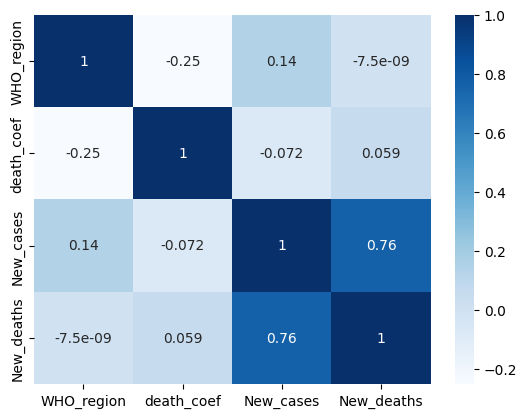

In [83]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data2 = data1.copy()
data2['WHO_region'] = le.fit_transform(data2['WHO_region'])

corr = data2[['WHO_region','death_coef', 'New_cases', 'New_deaths']].corr()

sb.heatmap(corr, cmap="Blues", annot=True)

Заметим, что между регионом и уровнем смертности присутствует слабая корреляция

# Динамика заболеваемости по странам

Функция где показан график заболеваемости для страны в определенный временной промежуток

In [90]:
def plot_covid(data_cov,
               symbol, start_date, end_date):
    data_plot = data_cov[data_cov['Country']==symbol][data_cov['Date_reported']>=start_date.strftime('%Y-%m-%d')]
    data_plot = data_plot[data_plot['Date_reported']<=end_date.strftime('%Y-%m-%d')]
    plt.plot(data_plot['Date_reported'], data_plot['New_cases'])
    plt.show()

Выберем пару стран из каждого региона:


*   AFRO - Central African Republic, Uganda
*   AMRO - Canada, Chile
*   EMRO - Afghanistan, Morocco
*   EURO - Russian Federation, France
*   SEARO - India, Thailand
*   WPRO - China, New Zealand



In [92]:
symbol_selector = ipywidgets.Dropdown(
    options=('India', 'Thailand', 'New Zealand', 'Central African Republic', 'Uganda', 'Chile',  'Russian Federation', 'Afghanistan', 'Morocco', 'China', 'France', 'Canada'),
    index=0,
    value='Russian Federation',
    layout={'width': '700px'},
    continuous_update=False
)

start_date_slider = ipywidgets.SelectionSlider(
    options=pd.date_range('2020-01-05', '2024-05-19', freq='D'),
    index=0,
    value=pd.Timestamp('2020-01-05'),
    layout={'width': '700px'},
    continuous_update=False
)

end_date_slider = ipywidgets.SelectionSlider(
    options=pd.date_range('2020-01-05', '2024-05-19', freq='D'),
    index=0,
    value=pd.Timestamp('2024-05-19'),
    layout={'width': '700px'},
    continuous_update=False
)

ipywidgets.interact(
    plot_covid,
    data_cov=ipywidgets.fixed(data_cov),
    symbol=symbol_selector,
    start_date=start_date_slider,
    end_date=end_date_slider
)

interactive(children=(Dropdown(description='symbol', layout=Layout(width='700px'), options=('India', 'Thailand…

<function __main__.plot_covid(data_cov, symbol, start_date, end_date)>

# Прогноз заболеваемости для России

In [93]:
data_rus = data_cov[data_cov['Country']=='Russian Federation'][['Date_reported','New_cases']]

In [94]:
data_rus['Date_reported'] = le.fit_transform(data_rus['Date_reported'])

In [95]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

X = data_rus[['Date_reported']]
Y = data_rus[['New_cases']]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=50, include_bias=False)
poly_features_train = poly.fit_transform(X_train)
poly_features_test = poly.fit_transform(X_test)

reg = LinearRegression().fit(poly_features_train, y_train)
res = reg.predict(poly_features_test)
print(r2_score(y_test, res))

0.020735149429598754


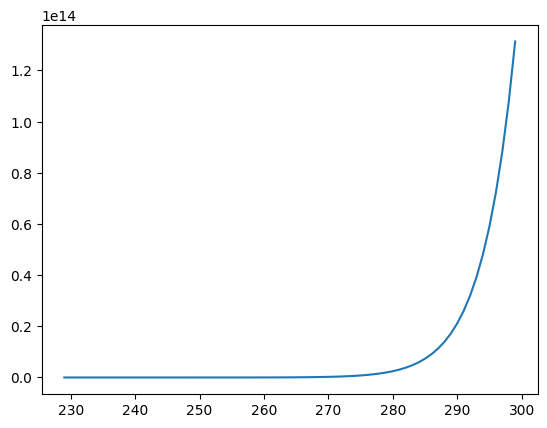

In [96]:
X_pred = np.arange(229, 300, 1).reshape(-1, 1)
poly_features_pred = poly.fit_transform(X_pred)
res = reg.predict(poly_features_pred)
plt.plot(X_pred, res)
plt.show()

Ожидается рост заболеваемости ковидом в России